In [13]:
import secml.data
import torch
from torchvision import transforms

from utils import download_gdrive
from secml.array import CArray
from secml.ml import CClassifierPyTorch
from models.models import SparseResNet18
import os
import torch.utils.data
from torchvision import datasets
import numpy as np
import foolbox as fb
import matplotlib.pyplot as plt
import pandas as pd
from secml.adv.attacks import CFoolboxPGDLinf
from secml.adv.seceval import CSecEval


# Load data and model

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1)


def load_model():
    MODEL_ID = '1Af_owmMvg1LxjITLE1gFUmPx5idogeTP'  # google drive id
    gamma = 0.1
    filepath = f'kwta_spresnet18_{gamma}_cifar_adv.pth'
    if not os.path.exists(filepath):
        download_gdrive(MODEL_ID, filepath)
    model = SparseResNet18(sparsities=[gamma, gamma, gamma, gamma], sparse_func='vol')
    state_dict = torch.load(filepath, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)
    return model


def load_data(data_dir, dataset_name, shuffle=True,
              train=True, transform=None, num_samples=None):
    tr = [transforms.ToTensor()]
    if transform is not None:
        tr = [transforms.ToTensor(), transforms.Lambda(transform)]
    transform = transforms.Compose(tr)

    if dataset_name == 'CIFAR10':
        dataset = datasets.CIFAR10(data_dir, train=train, transform=transform, download=True)
    elif dataset_name == 'MNIST':
        dataset = datasets.MNIST(data_dir, train=train, transform=transform, download=True)
    else:
        raise ValueError(f"Dataset {dataset_name} not available.")

    if shuffle is True:
        indexes = torch.randperm(len(dataset))
    else:
        indexes = torch.arange(0, len(dataset))

    if num_samples is not None:
        indexes = indexes[:min(len(dataset), num_samples)]
    dataset = torch.utils.data.Subset(dataset, indexes)
    loader = torch.utils.data.DataLoader(dataset, batch_size=N_SAMPLES)
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    return x, y


model = load_model()
# get samples from the dataset
N_SAMPLES = 10
images, labels = load_data('data', 'CIFAR10', num_samples=N_SAMPLES)
epsilons = np.linspace(0.0, 8 / 255, num=3)

Files already downloaded and verified


# Foolbox evaluation


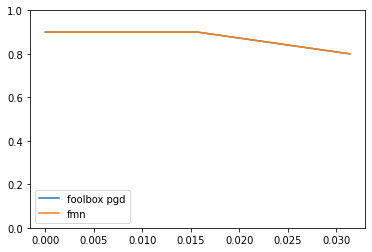

In [15]:
from attacks.fmn import LInfFMNAttack

bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds)
fmodel = fmodel.transform_bounds((0, 1))

attack = fb.attacks.LinfPGD(abs_stepsize=0.01, random_start=False)

raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)
robust_accuracy_foolbox = 1 - is_adv.type(torch.FloatTensor).mean(axis=-1)

plt.figure()
plt.plot(epsilons, robust_accuracy_foolbox.numpy(), label='foolbox pgd')

fmn = LInfFMNAttack(max_stepsize=10)
raw_fmn, clipped_fmn, is_adv_fmn = fmn(fmodel, images, labels, epsilons=epsilons)
robust_accuracy_foolbox_fmn = 1 - is_adv_fmn.type(torch.FloatTensor).mean(axis=-1)

plt.plot(epsilons, robust_accuracy_foolbox_fmn.numpy(), label='fmn')

plt.ylim([0, 1])
plt.legend()


# Secml Evaluation

In [16]:
clf = CClassifierPyTorch(model, input_shape=(3, 32, 32), pretrained=True,
                         pretrained_classes=CArray(list(range(10))), preprocess=None)

secml_attack = CFoolboxPGDLinf(clf, abs_stepsize=0.01, steps=40,
                               random_start=False)  # same params as the foolbox defaults

sec_eval = CSecEval(attack=secml_attack, param_name='epsilon', param_values=epsilons)

test_set = secml.data.CDataset(CArray(images.view(N_SAMPLES, -1).cpu()), CArray(labels.cpu()))
sec_eval.run_sec_eval(test_set)

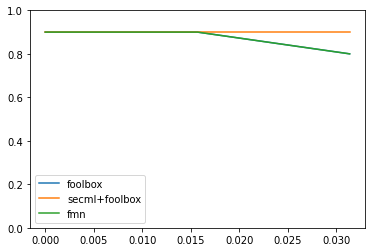

In [17]:
robust_accuracy_secml = [(sec_eval.sec_eval_data.Y_pred[i] == sec_eval.sec_eval_data.Y).mean() for i in
                         range(len(epsilons))]
plt.figure()
plt.plot(epsilons, robust_accuracy_foolbox.numpy(), label='foolbox')
plt.plot(epsilons, robust_accuracy_secml, label='secml+foolbox')
plt.plot(epsilons, robust_accuracy_foolbox_fmn.numpy(), label='fmn')

plt.ylim([0, 1])

plt.legend()

In [18]:
from indicators.indicators import compute_indicators

all_indicators = []

secml_attack_to_debug = CFoolboxPGDLinf(clf, abs_stepsize=0.01, steps=40,
                               random_start=False, epsilons=8/255)

for sample in range(N_SAMPLES):
    x, y = test_set.X[sample, :], test_set.Y[sample]
    pred = clf.predict(x)

    indicators = compute_indicators(secml_attack_to_debug, x, y, clf, transfer_clf=None, n_restarts=3)
    all_indicators.append(indicators)

all_indicators_orig_eval = pd.concat(all_indicators, axis=0)

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None):
    print(all_indicators_orig_eval)


2021-12-09 16:55:51,820 - py.warnings - WARNING - /home/maurapintor/PycharmProjects/debug_attacks/indicators/indicators.py:137: RuntimeWarning: Mean of empty slice.
  return (grad_norm[:how_many] <= threshold).mean()

2021-12-09 16:55:51,821 - py.warnings - WARNING - /home/maurapintor/miniconda3/envs/debug_attacks/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)

   Attack Success  Silent Success  Break-point Angle  Increasing Loss  \
0             0.0             0.0           0.659288         0.682614   
0             0.0             0.0           0.486804         0.693259   
0             0.0             1.0           0.538541         0.623399   
0             1.0             0.0           0.240400         0.620494   
0             0.0             1.0           0.159201         0.672005   
0             0.0             1.0           0.545638         0.696752   
0             0.0  

# First, let's fix the implementation

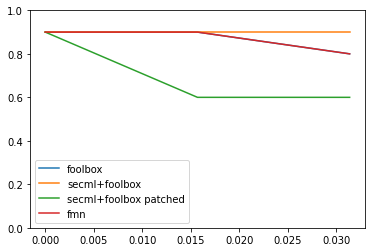

In [19]:
from attacks.pgd_best_point import CFoolboxPGDBest

patched_pgd = CFoolboxPGDBest(clf, abs_stepsize=0.01, steps=40,
                               random_start=False, epsilons=8/255)

sec_eval_patched = CSecEval(attack=patched_pgd, param_name='epsilon', param_values=epsilons)

test_set = secml.data.CDataset(CArray(images.view(N_SAMPLES, -1).cpu()), CArray(labels.cpu()))
sec_eval_patched.run_sec_eval(test_set)
robust_accuracy_secml_patched = [(sec_eval_patched.sec_eval_data.Y_pred[i] == sec_eval_patched.sec_eval_data.Y).mean() for i in
                         range(len(epsilons))]
plt.figure()
plt.plot(epsilons, robust_accuracy_foolbox.numpy(), label='foolbox')
plt.plot(epsilons, robust_accuracy_secml, label='secml+foolbox')
plt.plot(epsilons, robust_accuracy_secml_patched, label='secml+foolbox patched')
plt.plot(epsilons, robust_accuracy_foolbox_fmn.numpy(), label='fmn')
plt.ylim([0, 1])

plt.legend()

In [20]:
# Then, we can fix the noisy descent problem

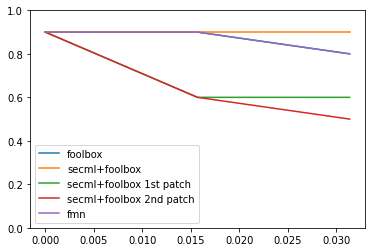

In [21]:
from attacks.pgd_noisy_descent import CFoolboxAveragedPGD

patched_and_smoothed_pgd = CFoolboxAveragedPGD(clf, abs_stepsize=0.01, steps=40,
                               random_start=False, epsilons=8/255, k=20)  # k is the number of neighbors for smoothing

sec_eval_patched_2 = CSecEval(attack=patched_and_smoothed_pgd, param_name='epsilon', param_values=epsilons)

test_set = secml.data.CDataset(CArray(images.view(N_SAMPLES, -1).cpu()), CArray(labels.cpu()))
sec_eval_patched_2.run_sec_eval(test_set)

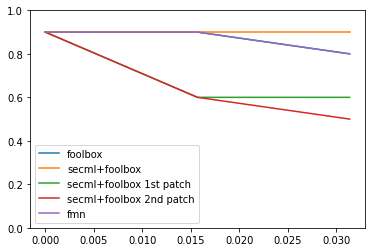

In [22]:
robust_accuracy_secml_patched_2 = [(sec_eval_patched_2.sec_eval_data.Y_pred[i] == sec_eval_patched_2.sec_eval_data.Y).mean() for i in
                         range(len(epsilons))]
plt.figure()
plt.plot(epsilons, robust_accuracy_foolbox.numpy(), label='foolbox')
plt.plot(epsilons, robust_accuracy_secml, label='secml+foolbox')
plt.plot(epsilons, robust_accuracy_secml_patched, label='secml+foolbox 1st patch')
plt.plot(epsilons, robust_accuracy_secml_patched_2, label='secml+foolbox 2nd patch')
plt.plot(epsilons, robust_accuracy_foolbox_fmn.numpy(), label='fmn')
plt.ylim([0, 1])

plt.legend()
